<a href="https://colab.research.google.com/github/bayusiddik/FinalProject-Viskom/blob/main/HelmetDetection_1301194031.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project Computer Vision**

**Membangun sistem deteksi ojek penggunaan helm.**

Nama : Muhammad Bayu Samudra Siddik

Nim  : 1301194031

---

## Import Library

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.python.util import compat
from tensorflow.core.protobuf import saved_model_pb2
from google.protobuf import text_format
import pprint
import os     

## Prepare Dataset

In [2]:
!ls /content

kaggle.json  sample_data


In [3]:
!mkdir -p /root/.kaggle/
!mv /content/kaggle.json /root/.kaggle/

In [4]:
!chmod 600 /root/.kaggle/kaggle.json

## Download HardHat and Safety Vest Image for Object Detection Dataset

In [5]:
!kaggle d download johnsyin97/hardhat-and-safety-vest-image-for-object-detection

100% 314M/315M [00:09<00:00, 40.6MB/s]
100% 315M/315M [00:09<00:00, 33.3MB/s]


In [6]:
!unzip hardhat-and-safety-vest-image-for-object-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/neg_716.jpg       
  inflating: train/neg_716.txt       
  inflating: train/neg_717.jpg       
  inflating: train/neg_717.txt       
  inflating: train/neg_718.jpg       
  inflating: train/neg_718.txt       
  inflating: train/neg_719.jpg       
  inflating: train/neg_719.txt       
  inflating: train/neg_72.jpg        
  inflating: train/neg_72.txt        
  inflating: train/neg_720.jpg       
  inflating: train/neg_720.txt       
  inflating: train/neg_721.jpg       
  inflating: train/neg_721.txt       
  inflating: train/neg_722.jpg       
  inflating: train/neg_722.txt       
  inflating: train/neg_723.jpg       
  inflating: train/neg_723.txt       
  inflating: train/neg_724.jpg       
  inflating: train/neg_724.txt       
  inflating: train/neg_725.jpg       
  inflating: train/neg_725.txt       
  inflating: train/neg_726.jpg       
  inflating: train/neg_726.txt       
  inflating: train/neg_727.jpg       

## Download Pretrained SSD MobileNet COCO/TACO/Hardhat/PoseNet

In [7]:

!kaggle d download bouweceunen/pretrained-trt-engines-cocotacohardhatposenet

100% 656M/657M [00:19<00:00, 41.5MB/s]
100% 657M/657M [00:19<00:00, 35.3MB/s]


In [8]:
!unzip pretrained-trt-engines-cocotacohardhatposenet.zip

Archive:  pretrained-trt-engines-cocotacohardhatposenet.zip
  inflating: base-models/resnet10_fd_lpd.caffemodel  
  inflating: base-models/resnet10_fd_lpd.prototxt  
  inflating: base-models/resnet18_posenet.pth  
  inflating: base-models/ssd_mobilenet_v2_coco_2018_03_29.pb  
  inflating: base-models/ssd_mobilenet_v2_hardhat_2018_03_29.pb  
  inflating: tensorrt5/resnet10_fd_lpd.engine  
  inflating: tensorrt5/ssd_mobilenet_v2_coco_2018_03_29.engine  
  inflating: tensorrt5/ssd_mobilenet_v2_coco_2018_03_29.uff  
  inflating: tensorrt5/ssd_mobilenet_v2_hardhat_2018_03_29.uff  
  inflating: tensorrt5/ssd_mobilenet_v2_taco_2018_03_29.engine  
  inflating: tensorrt5/ssd_mobilenet_v2_taco_2018_03_29.uff  
  inflating: tensorrt6/resnet10_fd_lpd.engine  
  inflating: tensorrt6/resnet18_posenet.engine  
  inflating: tensorrt6/resnet18_posenet.onnx  
  inflating: tensorrt6/ssd_mobilenet_v2_coco_2018_03_29.engine  
  inflating: tensorrt6/ssd_mobilenet_v2_coco_2018_03_29.uff  
  inflating: tensor

## Clone Tensoflow Model

In [9]:
! rm -rf ./models && git clone https://github.com/tensorflow/models.git \
    && cd models/research \
    && protoc object_detection/protos/*.proto --python_out=. \
    && cp object_detection/packages/tf2/setup.py . && \
    python3 -m pip install --use-feature=2020-resolver .

Cloning into 'models'...
remote: Enumerating objects: 80060, done.
remote: Counting objects: 100% (245/245), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 80060 (delta 119), reused 215 (delta 101), pack-reused 79815
Receiving objects: 100% (80060/80060), 594.48 MiB | 18.18 MiB/s, done.
Resolving deltas: 100% (56973/56973), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 14.5 MB 14.8 MB/s 
     |████████████████████████████████| 352 kB 34.5 MB

## Def Reconstruct Frozen Graph

In [10]:

from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import dataset_util, label_map_util
from object_detection.protos import string_int_label_map_pb2

In [11]:
def reconstruct(pb_path):
    if not os.path.isfile(pb_path):
        print("Error: %s not found" % pb_path)

    print("Reconstructing Tensorflow model")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(pb_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    print("Success!")
    return detection_graph

## Visualize Detection

In [12]:
def image2np(image):
    (w, h) = image.size
    return np.array(image.getdata()).reshape((h, w, 3)).astype(np.uint8)

def image2tensor(image):
    npim = image2np(image)
    return np.expand_dims(npim, axis=0)

%matplotlib inline
def detect(detection_graph, test_image_path):
    with detection_graph.as_default():
        gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.01)
        with tf.compat.v1.Session(graph=detection_graph,config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            image = Image.open(test_image_path)
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image2tensor(image)}
            )

            npim = image2np(image)
            vis_util.visualize_boxes_and_labels_on_image_array(
                npim,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=5)
            plt.figure(figsize=(12, 8))
            plt.imshow(npim)
            plt.show()

## Create Label Map

In [13]:
categories = ["helmet", "none"]
NCLASSES = 2

In [14]:
print('Building label map from examples')

labelmap = string_int_label_map_pb2.StringIntLabelMap()
for idx,category in enumerate(categories):
    item = labelmap.item.add()
    # label map id 0 is reserved for the background label
    item.id = idx+1
    item.name = category

with open('./labelmap.pbtxt', 'w') as f:
    f.write(text_format.MessageToString(labelmap))

print('Label map witten to labelmap.pbtxt')

with open('./labelmap.pbtxt') as f:
    pprint.pprint(f.readlines())

Building label map from examples
Label map witten to labelmap.pbtxt
['item {\n',
 '  name: "helmet"\n',
 '  id: 1\n',
 '}\n',
 'item {\n',
 '  name: "none"\n',
 '  id: 2\n',
 '}\n']


In [15]:
label_map = label_map_util.load_labelmap('labelmap.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NCLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Reconstruct Model

In [16]:
detection_graph = reconstruct("/content/base-models/ssd_mobilenet_v2_hardhat_2018_03_29.pb")

Reconstructing Tensorflow model
Success!


## Validate Images

### Import Dataset

In [17]:
!kaggle d download savanagrawal/detect-person-on-motorbike-or-scooter

 99% 348M/352M [00:10<00:00, 32.9MB/s]
100% 352M/352M [00:10<00:00, 34.4MB/s]


In [18]:
!mkdir ./motorbike
!unzip detect-person-on-motorbike-or-scooter.zip -d ./motorbike

Archive:  detect-person-on-motorbike-or-scooter.zip
  inflating: ./motorbike/chart.png   
  inflating: ./motorbike/coco.names  
  inflating: ./motorbike/dataset/obj/1 (1).jpg  
  inflating: ./motorbike/dataset/obj/1 (1).txt  
  inflating: ./motorbike/dataset/obj/1 (1)__flip.jpg  
  inflating: ./motorbike/dataset/obj/1 (1)__flip.txt  
  inflating: ./motorbike/dataset/obj/1.jpg  
  inflating: ./motorbike/dataset/obj/1.txt  
  inflating: ./motorbike/dataset/obj/10.jpg  
  inflating: ./motorbike/dataset/obj/10.txt  
  inflating: ./motorbike/dataset/obj/100.jpg  
  inflating: ./motorbike/dataset/obj/100.txt  
  inflating: ./motorbike/dataset/obj/100__flip.jpg  
  inflating: ./motorbike/dataset/obj/100__flip.txt  
  inflating: ./motorbike/dataset/obj/101.jpg  
  inflating: ./motorbike/dataset/obj/101.txt  
  inflating: ./motorbike/dataset/obj/101__flip.jpg  
  inflating: ./motorbike/dataset/obj/101__flip.txt  
  inflating: ./motorbike/dataset/obj/102.jpg  
  inflating: ./motorbike/dataset/ob

### Validate

In [19]:
import os
from PIL import Image
from IPython import display
import fnmatch
import random

In [20]:
path = r'./motorbike/dataset/obj/'
for dimage in fnmatch.filter(os.listdir(path),"*.jpg"):
  # set the base width of the result
  basewidth = 300
  img = Image.open(path+dimage)
  # determining the height ratio
  wpercent = (basewidth/float(img.size[0]))
  hsize = int((float(img.size[1])*float(wpercent)))
  # resize image and save
  img = img.resize((basewidth,hsize), Image.ANTIALIAS)
  img = img.convert('RGB')
  img.save(path+dimage) 
  pass
print(path,dimage)

./motorbike/dataset/obj/ 169__flip.jpg


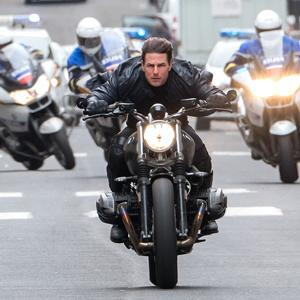

In [21]:
display.Image("/content/motorbike/dataset/obj/113__flip.jpg")

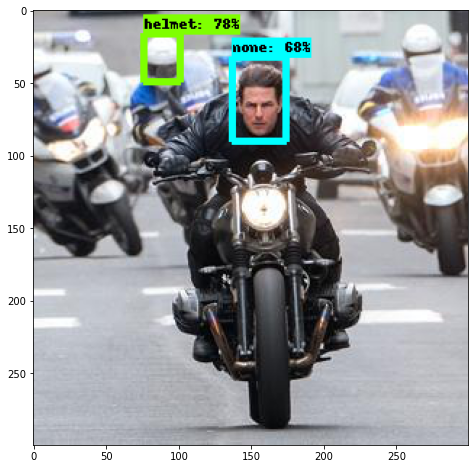

In [22]:
detect(detection_graph, f'./motorbike/dataset/obj/113__flip.jpg')

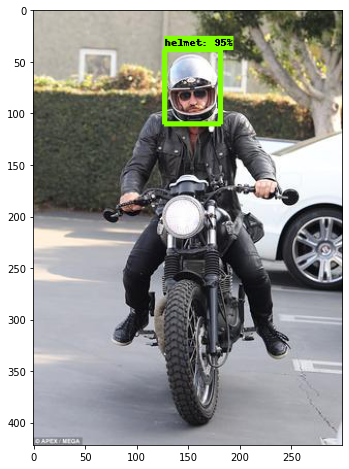

In [31]:
detect(detection_graph, f'./motorbike/dataset/obj/{random.randint(1,100)}.jpg')

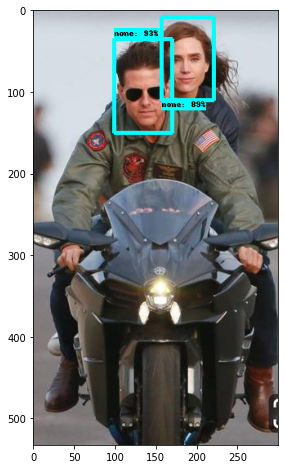

In [32]:
detect(detection_graph, f'./motorbike/dataset/obj/{random.randint(1,100)}.jpg')

## Eksperiment

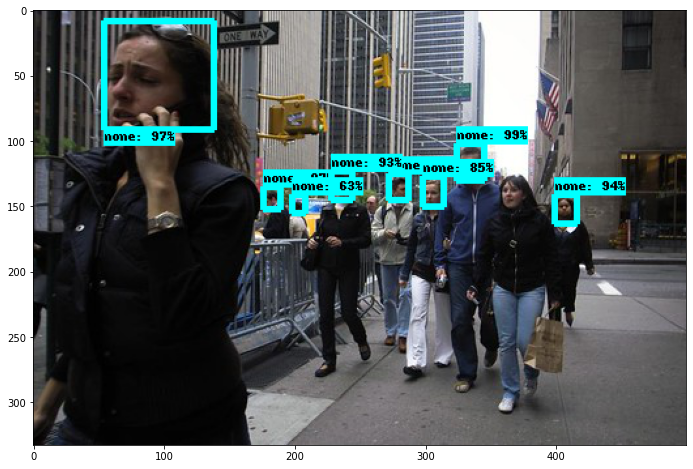

In [25]:
detect(detection_graph, '/content/train/neg_100.jpg')

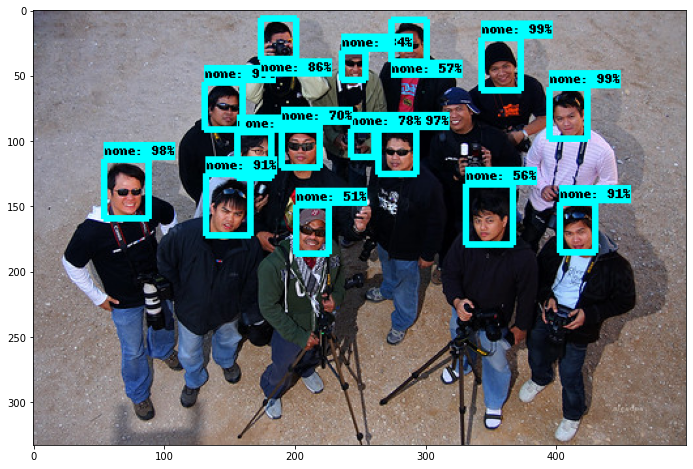

In [26]:
detect(detection_graph, '/content/train/neg_1099.jpg')

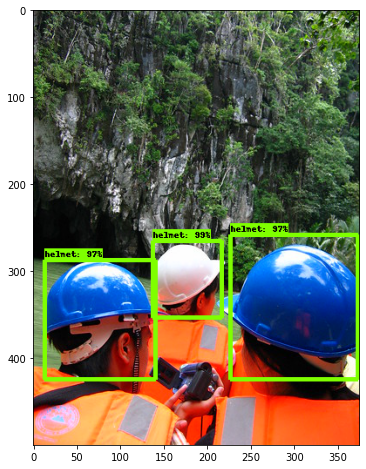

In [27]:
detect(detection_graph, '/content/train/pos_942.jpg')

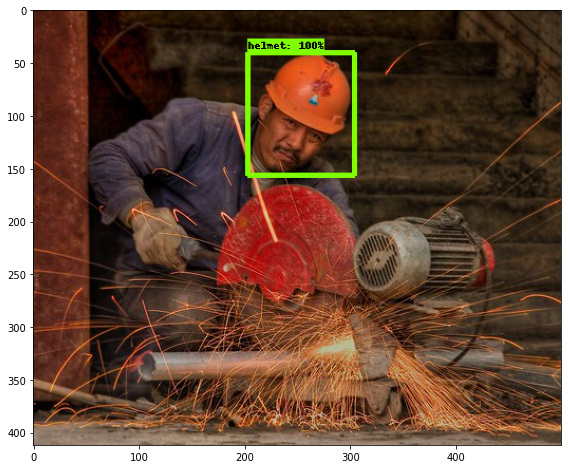

In [28]:
detect(detection_graph, '/content/train/pos_970.jpg')

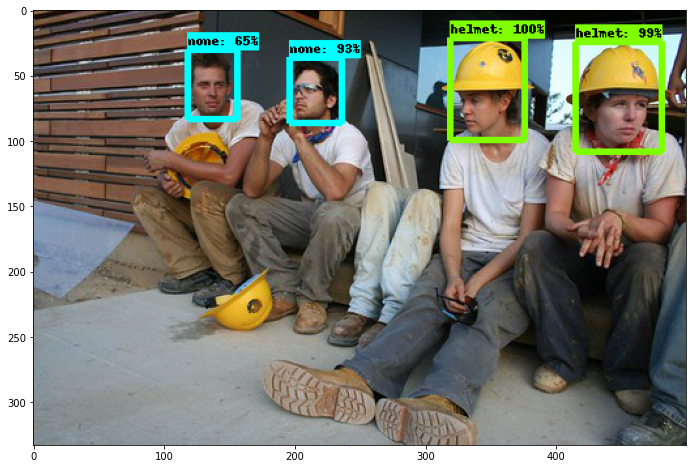

In [29]:
detect(detection_graph, '/content/train/pos_849.jpg')